**Brain Cancer Detection using MLP; CNN; Transformer and Vision Transformer**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**CNN**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

from torch.utils.data import Dataset
from sklearn.utils import shuffle
from PIL import Image
from glob import glob # different image format can be used
from sklearn.metrics import accuracy_score,confusion_matrix
import cv2
import sys



from torch.utils.data import DataLoader
from torchvision import transforms

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")

else:
    device = torch.device("cpu")





Reading the images


In [4]:
tumor = []
datafoler = '/content/drive/MyDrive/brain_tumor_dataset/yes'
for filename in os.listdir(datafoler):
  img = cv2.imread(os.path.join(datafoler,filename))
  img = cv2.resize(img,(128,128))
  b,g,r = cv2.split(img)
  img = cv2.merge([r,g,b])
  tumor.append(img)

len(tumor)

155

In [5]:
for img in tumor:
  print(img.shape)

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

In [6]:
healthy = []
datafoler = '/content/drive/MyDrive/brain_tumor_dataset/no'
for filename in os.listdir(datafoler):
  img = cv2.imread(os.path.join(datafoler,filename))
  img = cv2.resize(img,(128,128))
  b,g,r = cv2.split(img)
  img = cv2.merge([r,g,b])
  healthy.append(img)

len(healthy)

98

In [7]:
healthy = np.array(healthy)
tumor = np.array(tumor)

In [8]:
tumor.shape


(155, 128, 128, 3)

In [9]:
healthy.shape

(98, 128, 128, 3)

In [12]:
ALL = np.concatenate((tumor,healthy))

In [13]:
ALL.shape

(253, 128, 128, 3)

Visualizing Brain MRI Images


In [14]:
def plot_random(healthy,tumor,num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0],num,replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0],num,replace=False)]

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1,num,i+1)
        plt.title('healthy')


        plt.imshow(healthy_imgs[i])

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1,num,i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])


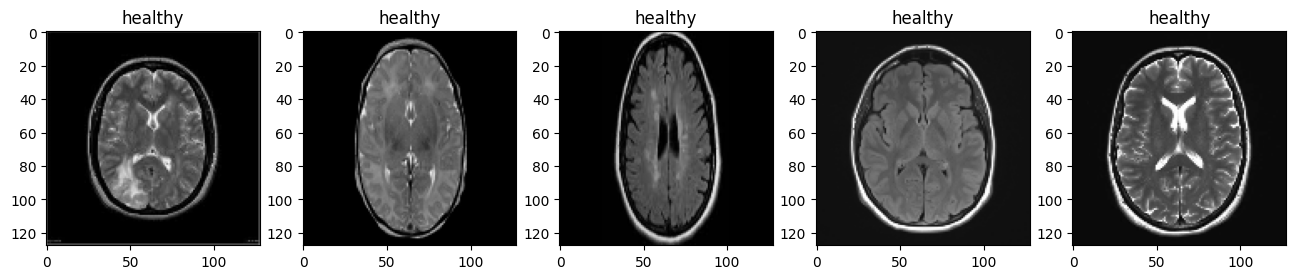

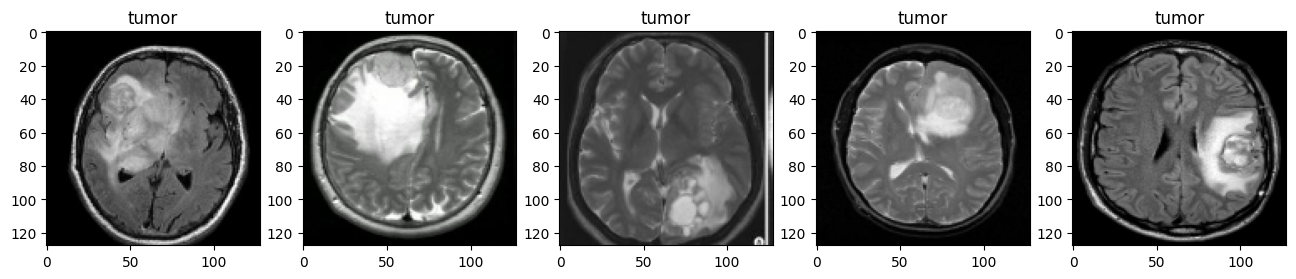

In [15]:
plot_random(healthy,tumor)

Creating Torch Dataset Class

In [16]:
class Dataset(object):

     def __getitem__(self, index):
        raise NotImplementedError

     def __len__(self):
        raise NotImplementedError

     def __add__(self, other):
        return ConcatDataset([self, other])


Creating MRI custom dataset class


In [17]:
class MRI(Dataset):
  def __init__(self):
    tumor = []

    datafoler = '/content/drive/MyDrive/brain_tumor_dataset/yes'
    for filename in os.listdir(datafoler):
        img = cv2.imread(os.path.join(datafoler,filename))
        img = cv2.resize(img,(128,128))
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b])
        img = img.reshape(img.shape[2], img.shape[0], img.shape[1])
        tumor.append(img)
    healthy = []
    datafoler = '/content/drive/MyDrive/brain_tumor_dataset/no'
    for filename in os.listdir(datafoler):
        img = cv2.imread(os.path.join(datafoler,filename))
        img = cv2.resize(img,(128,128))
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b])
        img = img.reshape(img.shape[2], img.shape[0], img.shape[1])
        healthy.append(img)

  # our images
    tumor = np.array(tumor,dtype=np.float32)
    healthy = np.array(healthy,dtype=np.float32)

  # our labels
    tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
    healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)

   # Concatenators
    self.images = np.concatenate((tumor, healthy), axis=0)
    self.labels = np.concatenate((tumor_label, healthy_label), axis=0)

 #   self.images = torch.from_numpy(self.images)
    self.labels = torch.from_numpy(self.labels)



  def __len__(self):
    return self.images.shape[0]


  def __getitem__(self,index):

    sample = {'image': self.images[index], 'label' : self.labels[index]}

    return sample

  def normalize(self):
    self.images = self.images / 255





In [18]:
mri = MRI()
mri.normalize()

In [19]:
img = mri[5]['image']

In [20]:
img.shape

(3, 128, 128)

Creating a dataloader

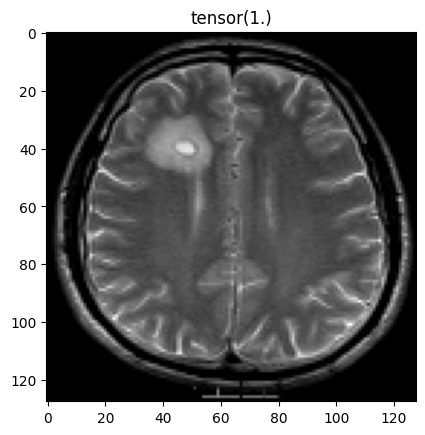

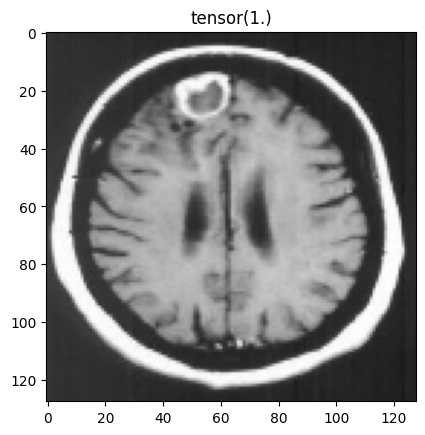

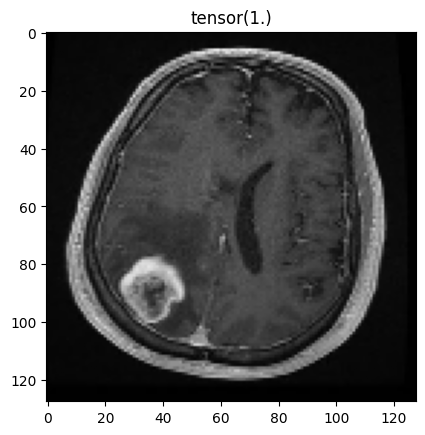

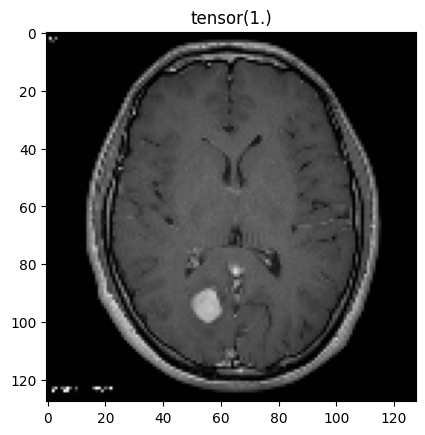

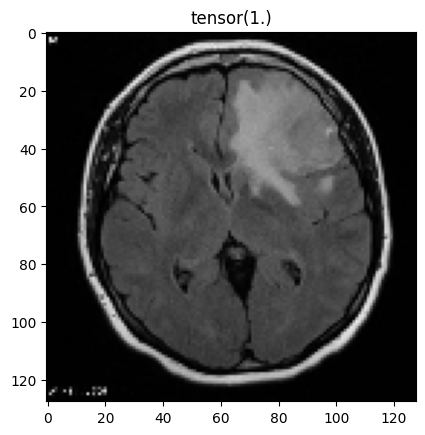

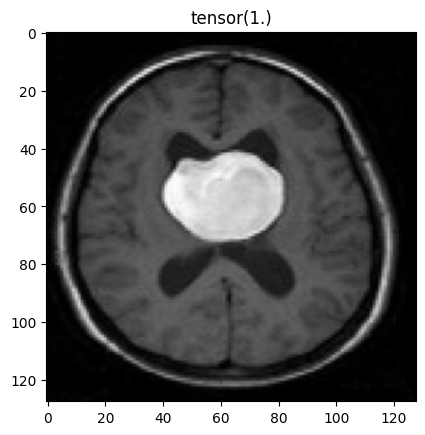

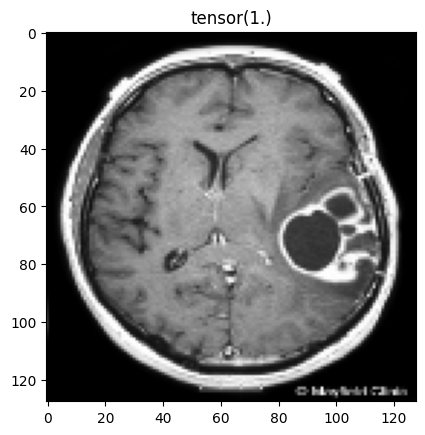

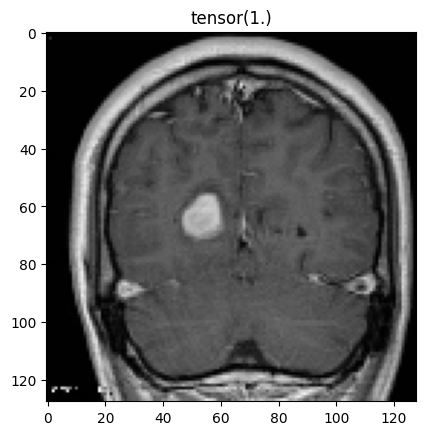

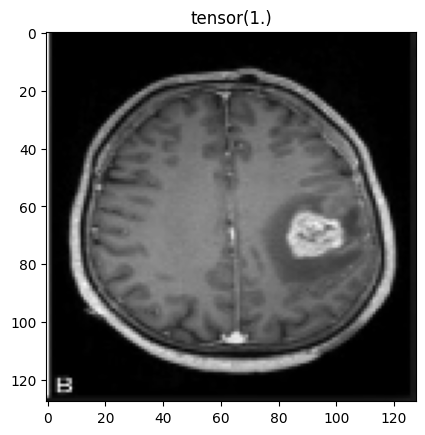

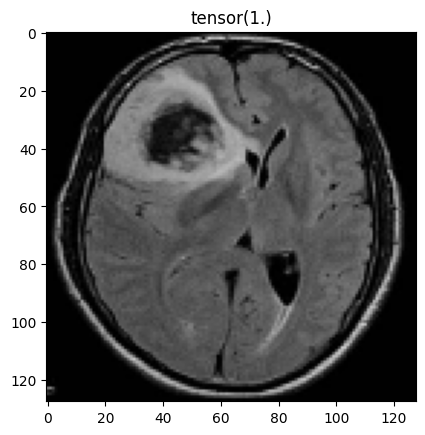

In [22]:
it = iter(mri)
for i in range(10):
  sample = next(it)
  img = sample['image']
  label = sample['label']
  img = img.reshape(img.shape[1], img.shape[2], img.shape[0])
  plt.title(label)
  plt.imshow(img)
  plt.show()

Dataloader

In [23]:
dataloader = DataLoader(mri, batch_size=10, shuffle=True)

In [24]:
for sample in dataloader:
    img = sample['image']
    print(img.shape)
    sys.exit()
 #   label = sample['label']
  #  img = img.reshape(img.shape[1], img.shape[0], img.shape[2])
   # plt.title(label)
    #plt.imshow(img)
    #plt.show()

torch.Size([10, 3, 128, 128])


SystemExit: 

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Model building

In [25]:


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define the CNN layers
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=5),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=5)
        )

        # Define the fully connected (fc) layers
        self.fc_model = nn.Sequential(
            nn.Linear(in_features=256, out_features=120),  # Adjust input features based on the output size of cnn_model
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=1)
        )

    def forward(self, x):
        # Forward pass through CNN layers
        x = self.cnn_model(x)

        # Flatten the output from convolutional layers before feeding to fully connected layers
        x = x.view(x.size(0), -1)

        # Forward pass through fully connected layers
        x = self.fc_model(x)

        # Apply sigmoid activation for binary classification
        x = F.sigmoid(x)

        return x


In [26]:
model = CNN()

In [27]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [28]:
model.cnn_model

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): Tanh()
  (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Tanh()
  (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
)

In [29]:
model.cnn_model[0]

Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))

In [30]:
model.cnn_model[0].weight

Parameter containing:
tensor([[[[ 8.2299e-02, -1.1525e-01, -1.0484e-01,  1.1121e-02, -6.0171e-02],
          [ 4.5256e-04, -2.1183e-02,  4.9304e-02,  1.1134e-01,  6.7713e-02],
          [-8.6124e-02, -4.3671e-02,  1.2903e-02, -6.4105e-03, -8.8240e-02],
          [-1.6278e-02,  2.9570e-02, -3.8232e-02, -2.1196e-02,  2.6916e-02],
          [ 1.1365e-01, -7.5970e-03,  8.5885e-02,  9.5622e-02,  6.8101e-03]],

         [[ 3.6626e-02, -7.1126e-02,  9.9437e-02,  4.9608e-02,  6.4165e-02],
          [-2.2400e-02,  9.1950e-02, -8.4991e-02,  5.5893e-02, -8.8348e-02],
          [ 6.4786e-02,  7.3202e-03,  9.5097e-02, -1.0697e-01,  2.1266e-03],
          [ 4.6414e-02,  4.0636e-02,  1.1272e-01,  2.3799e-02,  4.5445e-02],
          [ 1.6984e-02, -5.0149e-02, -2.7008e-02,  7.4730e-02, -3.2156e-02]],

         [[ 4.9078e-02,  8.2746e-02, -4.9569e-02,  7.7865e-02, -4.8379e-03],
          [-7.6895e-02,  6.6557e-02, -1.0940e-01, -9.2867e-03,  7.1890e-03],
          [ 7.4713e-02,  9.9483e-02,  2.5740e-02, 

In [31]:
model.cnn_model[0].weight.shape

torch.Size([6, 3, 5, 5])

In [32]:
model.cnn_model[0].weight[0][1]

tensor([[ 0.0366, -0.0711,  0.0994,  0.0496,  0.0642],
        [-0.0224,  0.0920, -0.0850,  0.0559, -0.0883],
        [ 0.0648,  0.0073,  0.0951, -0.1070,  0.0021],
        [ 0.0464,  0.0406,  0.1127,  0.0238,  0.0454],
        [ 0.0170, -0.0501, -0.0270,  0.0747, -0.0322]],
       grad_fn=<SelectBackward0>)

In [33]:
model.fc_model[0]

Linear(in_features=256, out_features=120, bias=True)

In [34]:
model.fc_model[0].weight.shape

torch.Size([120, 256])

Training model

In [35]:
eta = 0.0001
EPOCH = 150
optimer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader = DataLoader(mri, batch_size=10, shuffle=True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cpu_tensor = torch.rand(10).to(device)

gpu_tensor = cpu_tensor.to(device)

print(cpu_tensor, cpu_tensor.dtype, type(cpu_tensor), cpu_tensor.type())
print(gpu_tensor, gpu_tensor.dtype, type(gpu_tensor), gpu_tensor.type())

print(cpu_tensor*gpu_tensor)

tensor([0.1399, 0.2973, 0.9038, 0.6411, 0.4380, 0.1616, 0.7012, 0.4833, 0.2044,
        0.7043], device='cuda:0') torch.float32 <class 'torch.Tensor'> torch.cuda.FloatTensor
tensor([0.1399, 0.2973, 0.9038, 0.6411, 0.4380, 0.1616, 0.7012, 0.4833, 0.2044,
        0.7043], device='cuda:0') torch.float32 <class 'torch.Tensor'> torch.cuda.FloatTensor
tensor([0.0196, 0.0884, 0.8169, 0.4110, 0.1918, 0.0261, 0.4917, 0.2336, 0.0418,
        0.4960], device='cuda:0')


In [37]:
model = model.to(device)

for epoch in range(1, EPOCH):
    losses = []
    for D in dataloader:
        optimer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        #print(y_hat.shape)
        #print(label)


        # define loss function
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat, label.unsqueeze(1)))
        loss.backward()
        optimer.step()
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))

Train Epoch: 10	Loss: 0.599224
Train Epoch: 20	Loss: 0.537300
Train Epoch: 30	Loss: 0.511583
Train Epoch: 40	Loss: 0.491452
Train Epoch: 50	Loss: 0.482439
Train Epoch: 60	Loss: 0.412808
Train Epoch: 70	Loss: 0.383338
Train Epoch: 80	Loss: 0.345214
Train Epoch: 90	Loss: 0.324673
Train Epoch: 100	Loss: 0.282678
Train Epoch: 110	Loss: 0.267875
Train Epoch: 120	Loss: 0.219766
Train Epoch: 130	Loss: 0.198330
Train Epoch: 140	Loss: 0.166986
Train Epoch: 150	Loss: 0.139458


Evaluating the model

In [38]:
model.eval()
dataloader = DataLoader(mri, batch_size=36, shuffle=False)
outputs=[]
y_true=[]
with torch.no_grad():
     for D in dataloader:
         image = D['image'].to(device)
         label = D['label'].to(device)

         y_hat = model(image)

         outputs.append(y_hat.cpu().numpy())
         y_true.append(label.cpu().numpy())

outputs = np.concatenate(outputs, axis=0)
y_true = np.concatenate(y_true, axis=0)

In [39]:
accuracy_score(y_true, np.round(outputs))

0.9446640316205533

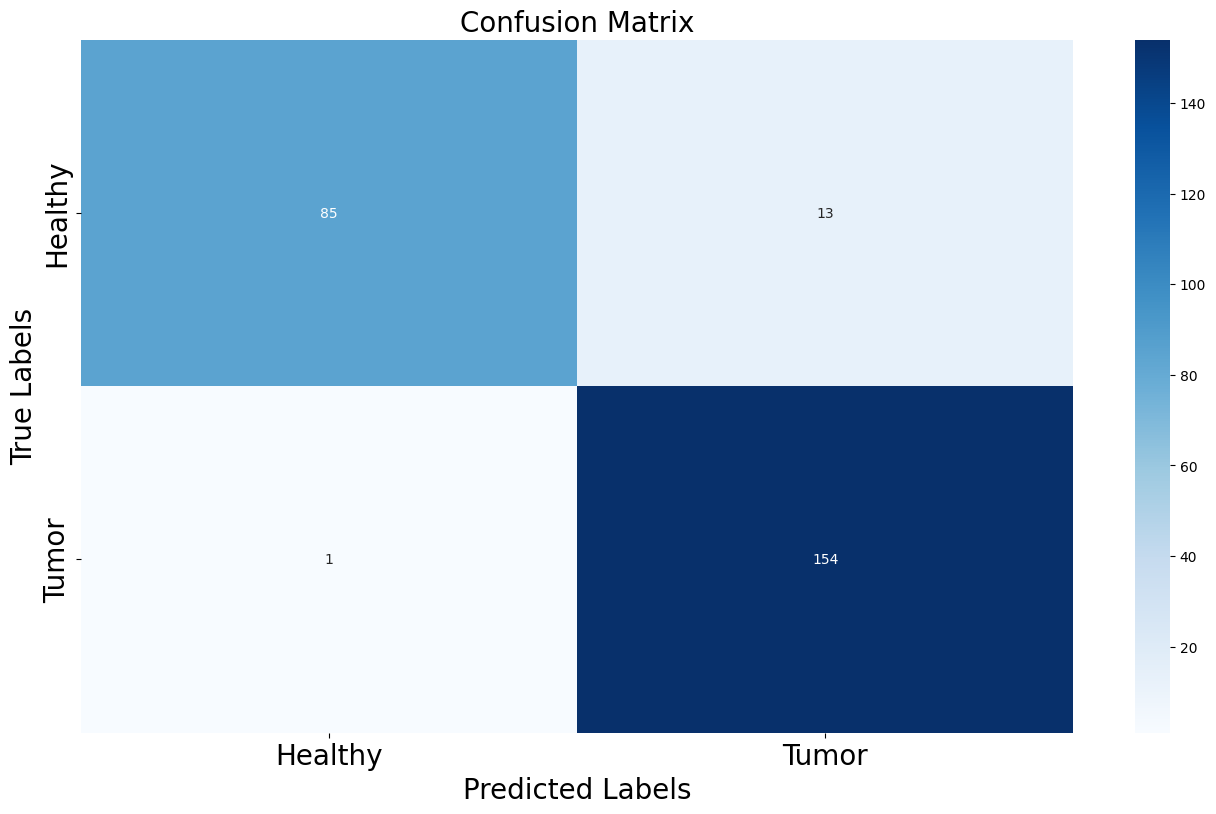

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Example y_true and outputs (you need to define these)
# y_true = [list of true labels]
# outputs = [list of predicted values/probabilities]

# Apply threshold (assuming binary classification, with threshold of 0.5)
threshold_value = 0.5
y_pred = (outputs >= threshold_value).astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define figure size
plt.figure(figsize=(16, 9))

# Create a subplot for heatmap
ax = plt.subplot()

# Plot the heatmap with annotations
sns.heatmap(cm, annot=True, cmap='Blues', fmt="d", ax=ax)

# Set axis labels and title
ax.set_xlabel('Predicted Labels', fontsize=20)
ax.set_ylabel('True Labels', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=20)

# Customize tick labels (make sure these match your classification classes)
tick_labels = ['Healthy', 'Tumor']  # Adjust this based on your dataset
ax.xaxis.set_ticklabels(tick_labels, fontsize=20)
ax.yaxis.set_ticklabels(tick_labels, fontsize=20)

# Show the plot
plt.show()


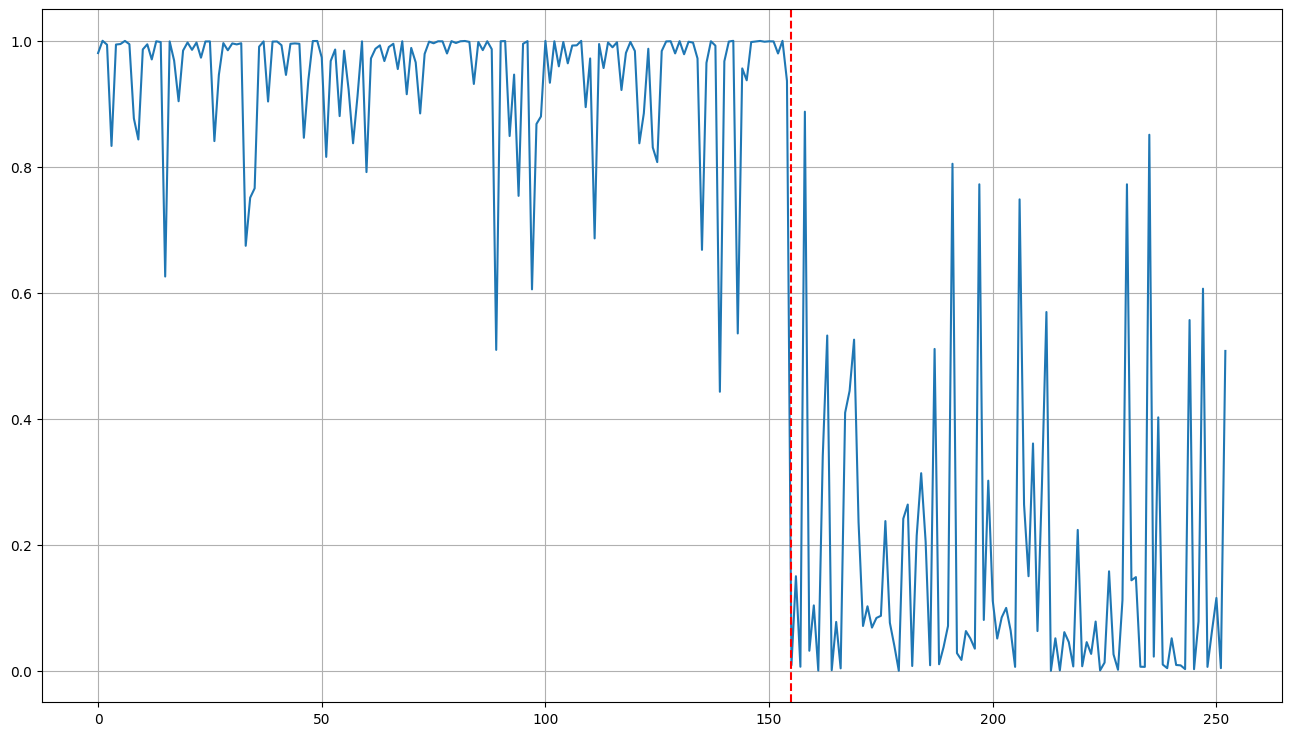

In [41]:
plt.figure(figsize=(16, 9))

# Plot the outputs
plt.plot(outputs)

# Draw a vertical line at x = len(tumor)
plt.axvline(x=len(tumor), color='r', linestyle='--')

# Enable grid
plt.grid()

# Show the plot
plt.show()
